# **S&P 500 index forecasting**

Hello,

My name is **Anas HAMOUTNI** and I am a **Moroccan Data Scientist**.

This project's goal is to implement different forecasting models to predict the **S&P 500 index price** based on various **Time series models** (ARIMA, LSTM...).

The **S&P 500** is a **stock market index** based on **500 large companies** listed on stock exchanges in the United States. The index is owned and managed by **Standard & Poor's**, one of the three major credit rating companies. **It covers** approximately **80%** of the **U.S. stock market** by capitalization.




In [745]:
#@title ##**Install necessary libraries** { display-mode: "form" }

!pip install yfinance --upgrade --no-cache-dir
!pip install pmdarima

from IPython.display import clear_output
clear_output()

In [746]:
#@title ##**Import necessary libraries** { display-mode: "form" }
import yfinance as yf
from dateutil.parser import parse
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
import pmdarima
from pmdarima import auto_arima
import matplotlib.ticker as mtick
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from  sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from sklearn.metrics import mean_absolute_error


clear_output()


In [747]:
#@title ##**Download the S&P 500 monthly price series** { display-mode: "form" }

SP500_price_data = yf.download(tickers = "SPY", period = "max", interval = "1mo") #download price & volume data of SPY from Yahoo Finance
SP500_price_data=SP500_price_data['Adj Close']*10 #extract the adjusted close price and multiply by a factor of 10 to turn it into S&P 500 price

print("We have "+ str(len(SP500_price_data))+" months of data starting from " + str(SP500_price_data.index[0].year) +"-"+str(SP500_price_data.index[0].month)+"-"+str(SP500_price_data.index[0].day))

[*********************100%***********************]  1 of 1 completed
We have 359 months of data starting from 1993-2-1


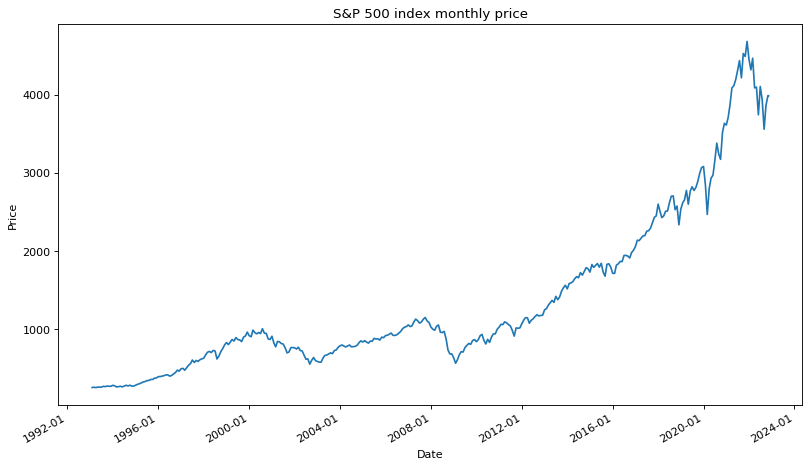

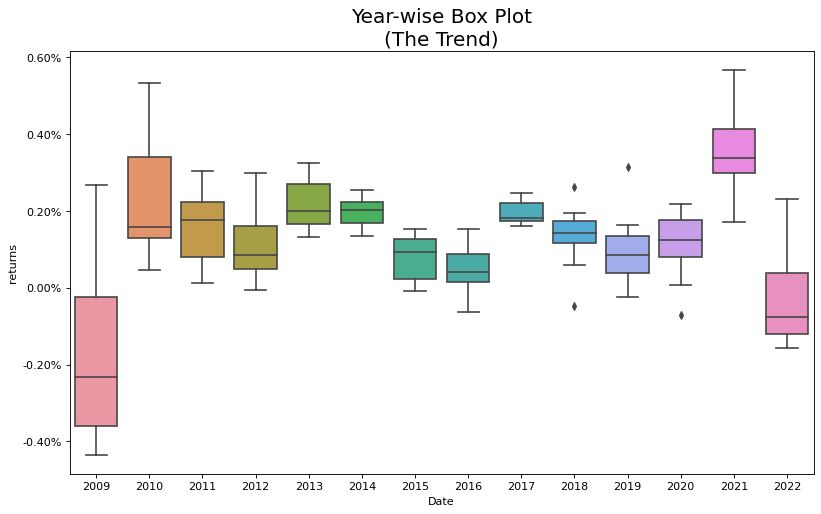

Note:

After the 2008/2009 financial crisis volatility in the US market went down, but it started to return back during the last 4 years which might be a sign of a coming recession.


In [748]:
#@title ##**Visualizing Data** { display-mode: "form" }
#Plotting the S&P 500 series
fig, ax = plt.subplots(figsize=(12,7), dpi= 80) #fixing width and height of the coming plots
SP500_price_data.plot() #plot the S&P 500 price data
plt.xlabel('Date') #setting x-axis label
plt.ylabel('Price')#setting y-axis label
plt.title('S&P 500 index monthly price') #setting the plot's title
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #remove days from Date in x-axis
plt.show() #show the plot

#Plotting the boxplot chart to analyze the volatility
last15=SP500_price_data[-180:] #extract the last 180 months or 15 years of S&P 500 price data
returns=[(x/y)-1 for x,y in zip(last15[-168:],last15[-180:-12])] #calculating the monthly returns over the last 180 months or 15 years
returns=pd.DataFrame({"index":last15[-168:],"returns":returns}) #construct returns dataframe
returns.set_index("index") #set index to be the first column of the dataframe
returns.drop("index", axis=1) #drop the first column

fig, axes = plt.subplots(figsize=(12,7), dpi= 80) #set boxplot width and height
sns.boxplot(x=returns.index.year, y=returns["returns"], data=returns, ax=axes); #plot via seaborn library
axes.set_title('Year-wise Box Plot\n(The Trend)', fontsize=18) #set boxplot title
axes.yaxis.set_major_formatter(mtick.PercentFormatter()) #format y-axis label to percent

plt.show() #show the boxplot
print("Note:\n")
print("After the 2008/2009 financial crisis volatility in the US market went down, but it started to return back during the last 4 years which might be a sign of a coming recession.")



# **Time Series Stationarity**

A **stationary** time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with **trends**, or with **seasonality**, are **not stationary**. On the other hand, a **white noise** series is **stationary** — it does not matter when you observe it, it should look much the same at any point in time.

**Stationarity** is important because many useful analytical tools and statistical tests and models rely on it.

In the next section we will check for stationarity in the **S&P 500** price data and we will start by **decomposing** the signal.

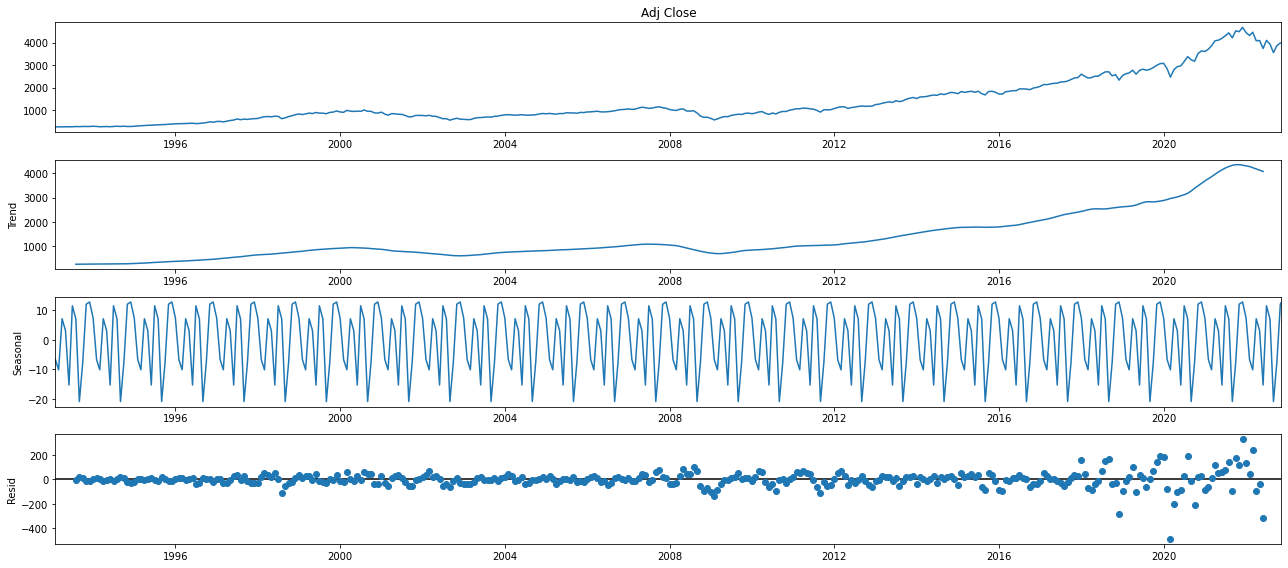

Comment:

We can easily see with a period of 12 months, S&P500 adjusted close price represent a clear upward trend over the last 3 decades and we also notice that residuals start to break stationarity over the last 6 years.


In [749]:
#@title ##**Time Series Decomposition** { display-mode: "form" }
rcParams['figure.figsize'] = 18, 8 #fix the dimensions of the coming plots
SP500_price_data=pd.DataFrame(SP500_price_data) #convert S&P 500 price data into a dataframe
decomposition = sm.tsa.seasonal_decompose(SP500_price_data["Adj Close"], model='Additive', period=12) #decomposing the S&P 500 signal using a 12-month moving average
fig = decomposition.plot() # plot the decomposition of the signal
plt.show() #show the plot

#Comment
print("Comment:\n")
print("We can easily see with a period of 12 months, S&P500 adjusted close price represent a clear upward trend over the last 3 decades and we also notice that residuals start to break stationarity over the last 6 years.")


Comment:
From the ACF plot we can see that there is no seasonality in the data and we can notice that the first 25 lags have significant correlation with the original series.
Comment:
We notice that the first lag contributes in a major way to the original series. Other lags contribute in a very small way.


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


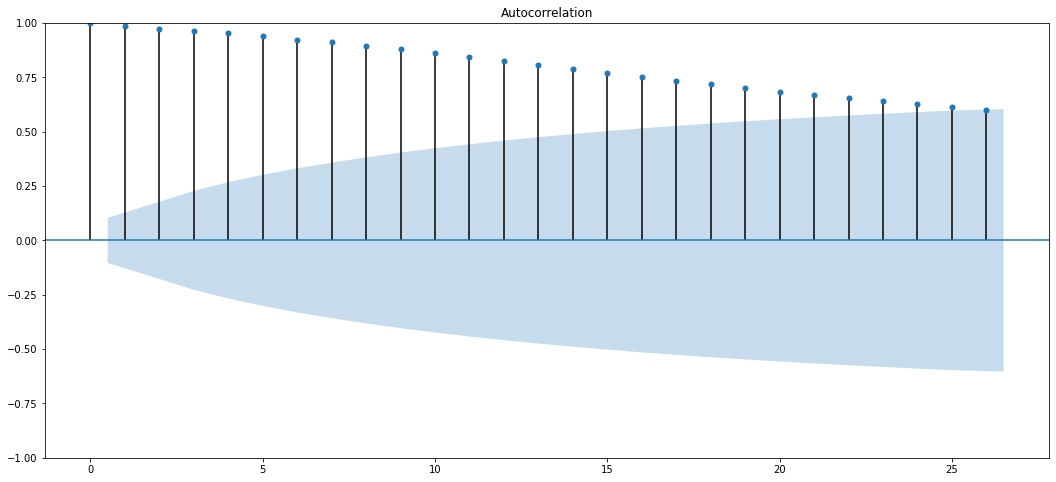

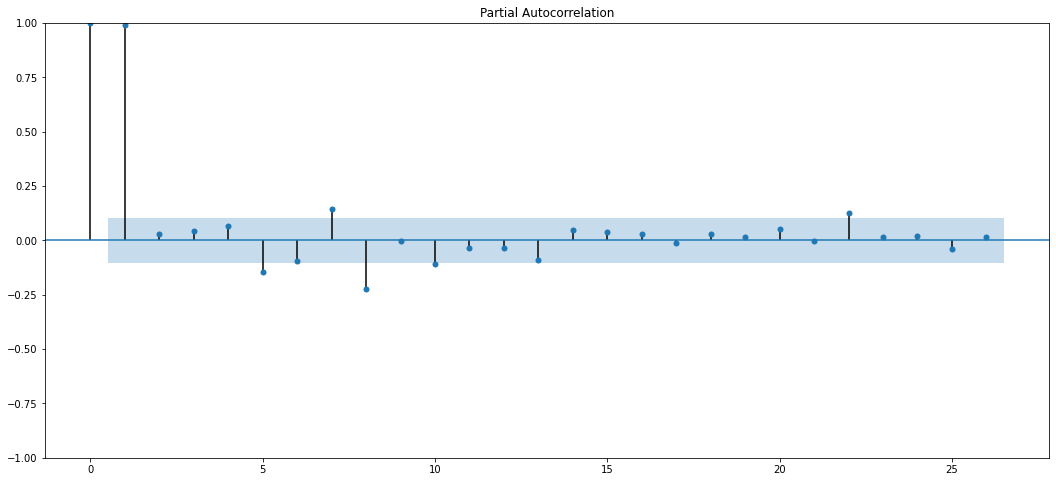

In [750]:
#@title ##**Check for Autocorrelation and Partial Autocorrelation** { display-mode: "form" }

acf=plot_acf(SP500_price_data["Adj Close"]) #Plot the Autocorrelation function
print("Comment:")
print("From the ACF plot we can see that there is no seasonality in the data and we can notice that the first 25 lags have significant correlation with the original series.")
pacf=plot_pacf(SP500_price_data["Adj Close"]) #Plot the Partial Autocorrelation function
print("Comment:")
print("We notice that the first lag contributes in a major way to the original series. Other lags contribute in a very small way.")


In [751]:
#@title ##**Check for Stationarity with Dickey-Fuller Test (threshold of 5%)** { display-mode: "form" }
print('Results of Dickey-Fuller Test:')
dftest = adfuller(SP500_price_data["Adj Close"], autolag='AIC') #perform stationary test
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) #output important values relative to the stationarity test
print (dfoutput) #print the output

#Comment
print("As the p-value is not less than our threshold of 5% we fail to reject the null-hypothesis, thus this series is non-stationary")

Results of Dickey-Fuller Test:
Test Statistic                   2.702246
p-value                          0.999087
#Lags Used                      14.000000
Number of Observations Used    344.000000
dtype: float64
As the p-value is not less than our threshold of 5% we fail to reject the null-hypothesis, thus this series is non-stationary


Test Statistic                -9.995925e+00
p-value                        1.940399e-17
#Lags Used                     2.000000e+00
Number of Observations Used    3.550000e+02
dtype: float64
As the p-value is less than 1% we reject the null-hypothesis, thus the log-difference is stationary with 99% confidence!


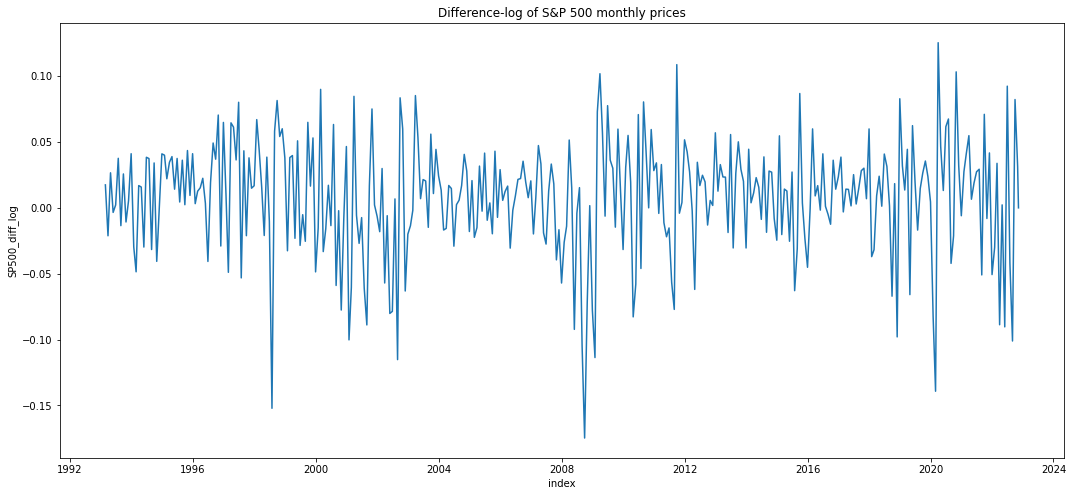

In [752]:
#@title ##**Make the Series Stationary by Differencing its Log** { display-mode: "form" }

#Differenceing the Log
SP500_log=np.log(SP500_price_data["Adj Close"]) #log the S&P 500 price data
SP500_diff_log = np.log(SP500_price_data["Adj Close"]) - np.log(SP500_price_data["Adj Close"]).shift() #First difference of log price data of S&P 500 
plt.plot(SP500_diff_log) #plotting the difference Log
plt.xlabel('index') #labeling the x-axis
plt.ylabel('SP500_diff_log') #labeling the y-axis
plt.title('Difference-log of S&P 500 monthly prices') #giving title to plot

#Check for stationarity
dftest = adfuller(SP500_diff_log[1:], autolag='AIC') #Test for Diff_log stationarity
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) #output important values relative to the stationarity test
print (dfoutput)

#Comment
print("As the p-value is less than 1% we reject the null-hypothesis, thus the log-difference is stationary with 99% confidence!")

# **Time Series Forecasting with ARIMA**

**ARIMA** is an acronym for **AutoRegressive Integrated Moving Average** (in this context, **“integration”** is the reverse of **differencing**). The full model can be written as:
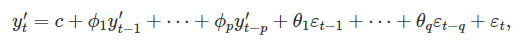

where **Yt'** is the differenced series (it may have been differenced more than once). The **“predictors”** on the right hand side include both lagged values of **Yt'** and lagged errors. We call this an **ARIMA(p,d,q)** model, where:

*   **p** = order of the autoregressive part;
*   **d** = degree of first differencing involved;
*   **q** = order of the moving average part.

Many of the models discussed in time series forecasting are just special cases of the **ARIMA** model, as shown in the table below:

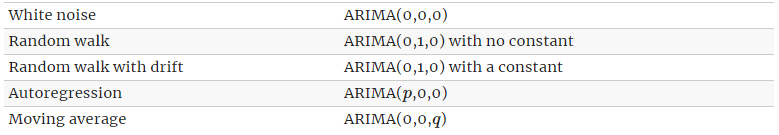

Next, we will prepare our data for forecasting and we will hyper-tune our **p**, **d**, and **q** parameters using the **auto_arima** function in order to fit the best model and run predictions.


In [753]:
#@title ##**Split Data** { display-mode: "form" }
#@markdown **Choose the Split ratio for train/test:**
Split_ratio= 0.9 #@param {type: "slider", min:0, max:1, step:0.1}
train= SP500_price_data["Adj Close"][:int(Split_ratio*len(SP500_price_data["Adj Close"]))] # S&P 500 price Training Data
test= SP500_price_data["Adj Close"][int(Split_ratio*len(SP500_price_data["Adj Close"])):] # S&P 500 price Test data


In [708]:
#@title ##**Automatically discover the optimal order for an ARIMA model** { display-mode: "form" }

best=auto_arima(train, test='adf',seasonal=True, trace=True, error_action='ignore', suppress_warnings=True) #The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3401.624, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3402.873, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3402.500, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3402.523, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3411.612, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3406.515, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3406.498, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3407.357, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3403.583, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3404.499, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3405.575, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3404.597, Time=0.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3403.957, Time=1.24 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3404.900, Time=0.56 sec

Best model:  ARIMA(2,1,2)(0,0,0)

In [754]:
#@title ##**Fit the Best ARIMA model** { display-mode: "form" }

model=ARIMA(train, order=best.order).fit() #fit the best ARIMA model
clear_output()

In [710]:
#@title ##**Making Predictions** { display-mode: "form" }

pred= model.predict(start=len(train), end=(len(SP500_price_data["Adj Close"])-1),dynamic=True) #Predict based on the Best ARIMA model and the training set


In [755]:
#@title ##**Evaluating the ARIMA model** { display-mode: "form" }

mae= mean_absolute_error(test, pred) #Calculating the Mean Absolute Error (MAE) between the test set and the predictions

print('MAE: %f' %mae) #Printing the MAE value

MAE: 439.376878


Comment:
We notice that the predictions is almost linear and captures the trend but not the noise because we're trying to predict many steps ahead. In the next model we will try to predict one step forward based on a training window.


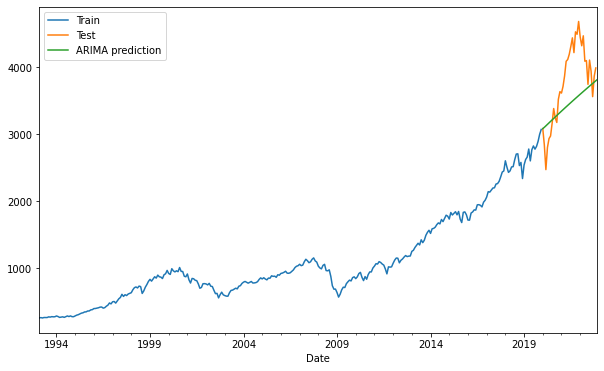

In [756]:
#@title ##**Plotting the Prediction vs Test** { display-mode: "form" }

train.plot(legend=True, label='Train', figsize=(10,6)) #plot the training data

test.plot(legend=True, label= 'Test') #plot the test data

pred.plot(legend=True, label='ARIMA prediction') #plot the predictions

print("Comment:")
print("We notice that the predictions is almost linear and captures the trend but not the noise because we're trying to predict many steps ahead. In the next model we will try to predict one step forward based on a training window.")

# **Time Series Forecasting with LSTMs**

**Long Short Term Memory** networks (**LSTM**s) are a special kind of **RNN**, capable of learning long-term dependencies. 

The problem with **Recurrent Neural Network**s is that they have a **short-term memory** to retain previous information in the current neuron. However, this ability decreases very quickly for longer sequences. As a remedy for this, the **LSTM models** were introduced to be able to retain past information even longer.

The problem with **Recurrent Neural Networks** is that they simply store the previous data in their **“short-term memory”**. Once the memory in it runs out, it simply deletes the longest retained information and replaces it with new data. 

The **LSTM model** attempts to escape this problem by **retaining only selected information in short-term memory**. This **short-term memory** is stored in the so-called **Cell State**. In addition, there is also the **hidden state**, which we already know from normal neural networks.

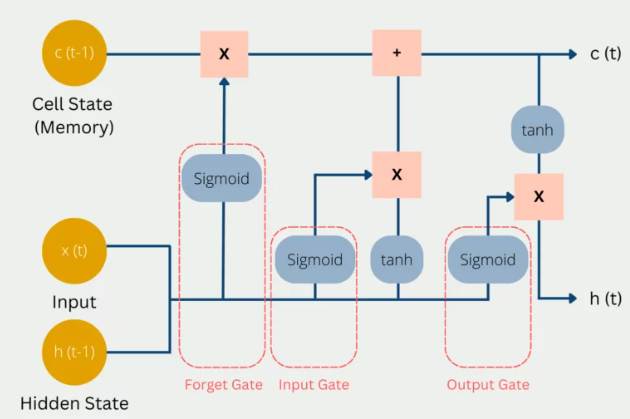

**LSTM**s are usually used to recognize patterns in data sequences, such as those that appear in **sensor data**, **stock prices**, or **natural language**.



In [757]:
#@title ##**Standardize and Split the Data** { display-mode: "form" }
 #@markdown **Choose the Split ratio for train/test:**
Split_ratio= 0.8 #@param {type: "slider", min:0, max:1, step:0.1}
data_mean=SP500_price_data.mean()
data_std=SP500_price_data.std()
SP500_price_data=(SP500_price_data-data_mean)/data_std #Standardizing data
train= SP500_price_data[0:int(Split_ratio*len(SP500_price_data[1:]))] # S&P 500 price Training Data
test= SP500_price_data[int(Split_ratio*len(SP500_price_data[1:])):] # S&P 500 price Testing Data
SP500_price_data=(SP500_price_data*data_std) + data_mean #convert data to original scale


,Adj Close
Date,
1993-02-01,256.043091
1993-03-01,260.547657
1993-04-01,255.079994
1993-05-01,261.959267
1993-06-01,261.054020
...,...
2022-08-01,3935.632935
2022-09-01,3557.187500
2022-10-01,3862.099915


In [758]:
#@title ##**Preparing Windowed Data for LSTM** { display-mode: "form" }

def create_dataset(dataset, time_steps): #function converting original data into a windowed dataset 
	dataX, dataY = [], []
	for i in range(len(dataset)-time_steps-1):
		a = dataset.iloc[i:(i+time_steps), 0]
		dataX.append(a)
		dataY.append(dataset.iloc[i + time_steps, 0])
	return np.array(dataX), np.array(dataY)


In [760]:
#@title ##**Preparing Data for LSTM** { display-mode: "form" }
#@markdown **Choose the Time steps to look-back:**
time_steps = 4 #@param {type: "slider", min:0, max:30, step:1}
# reshape into X=t and Y=t+time_steps
X_train, y_train = create_dataset(train, time_steps) #Prepare training data
X_test, y_test = create_dataset(test, time_steps) #Prepare testing data

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) 
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_test_0=X_test[0][0]


In [761]:
#@title ##**Build LSTM model** { display-mode: "form" }
model = keras.Sequential() #initialization of sequential
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True), input_shape=(1, time_steps))) #First layer
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128))) #Second Layer
model.add(keras.layers.Dropout(0.3)) # Droping out 30% of the nodes
model.add(keras.layers.Dense(units=40)) #Third Layer
model.add(keras.layers.Dropout(0.2)) # Droping out 20% of the nodes
model.add(keras.layers.Dense(units=1)) # Output layer
model.compile(loss='mae', optimizer=keras.optimizers.Adam()) # Compile the model with Mean Average Error loss type and Adam optimizer

In [762]:
#@title ##**Fit LSTM model** { display-mode: "form" }

history = model.fit( # Fit the model
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/100
4/4 [==============================] - 18s 2s/step - loss: 0.5020 - val_loss: 0.4279
Epoch 2/100
4/4 [==============================] - 0s 47ms/step - loss: 0.3454 - val_loss: 0.4263
Epoch 3/100
4/4 [==============================] - 0s 84ms/step - loss: 0.1898 - val_loss: 0.4107
Epoch 4/100
4/4 [==============================] - 0s 67ms/step - loss: 0.1531 - val_loss: 0.3915
Epoch 5/100
4/4 [==============================] - 0s 56ms/step - loss: 0.1312 - val_loss: 0.3960
Epoch 6/100
4/4 [==============================] - 0s 59ms/step - loss: 0.1006 - val_loss: 0.3856
Epoch 7/100
4/4 [==============================] - 0s 64ms/step - loss: 0.1255 - val_loss: 0.3633
Epoch 8/100
4/4 [==============================] - 0s 51ms/step - loss: 0.1105 - val_loss: 0.3309
Epoch 9/100
4/4 [==============================] - 0s 49ms/step - loss: 0.1034 - val_loss: 0.2935
Epoch 10/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0853 - val_loss: 0.2682
Epoch 11/100
4/4 [==

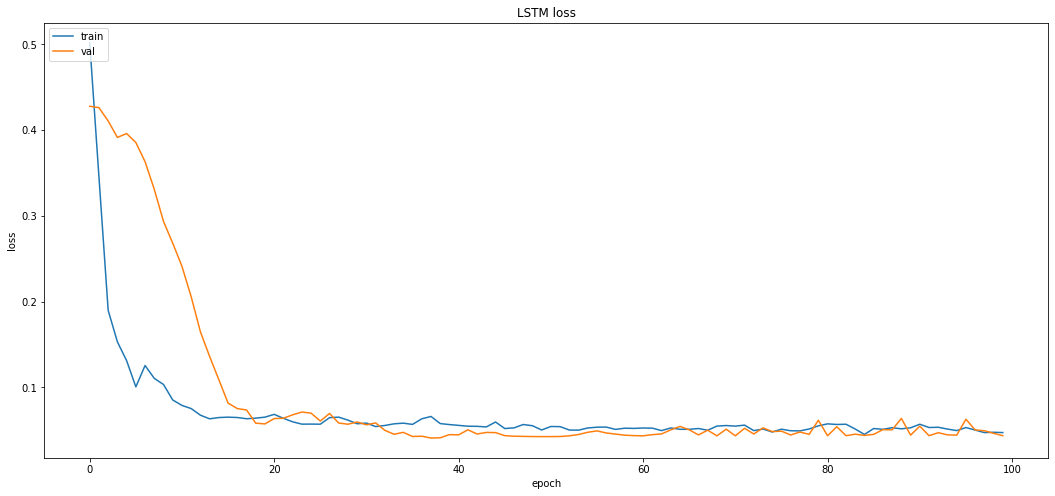

In [763]:
#@title ##**Plot the Loss** { display-mode: "form" }

plt.plot(history.history['loss']) #Plotting the training loss of the model per epoch
plt.plot(history.history['val_loss']) #Plotting the validation loss of the model per epoch
plt.title('LSTM loss') #Giving the plot a title
plt.ylabel('loss') #Giving the y-axis a label
plt.xlabel('epoch') #Giving the x-axis a label
plt.legend(['train', 'val'], loc='upper left') #Giving the plot a legend
plt.show() #Display the plot

In [764]:
#@title ##**Predict** { display-mode: "form" }

y_pred = model.predict(X_test)

3/3 [==============================] - 3s 7ms/step


In [765]:
#@title ##**Unstandardizing Data for Predictions plot** { display-mode: "form" }

y_pred=np.array([(y*data_std +data_mean) for y in y_pred]) #unstandardizing y_pred
y_test=np.array([(y*data_std +data_mean) for y in y_test]) #unstandardizing y_test
y_train=np.array([(y*data_std +data_mean) for y in y_train]) #unstandardizing y_train

MAE: 281.84419142780996
Comment:
As we can see the MAE is very low but we can't compare with the previous model's MAE as it's not the same type of forecasting, because here we forcast one step at a time but in the previous one we forecasted many steps forward. 


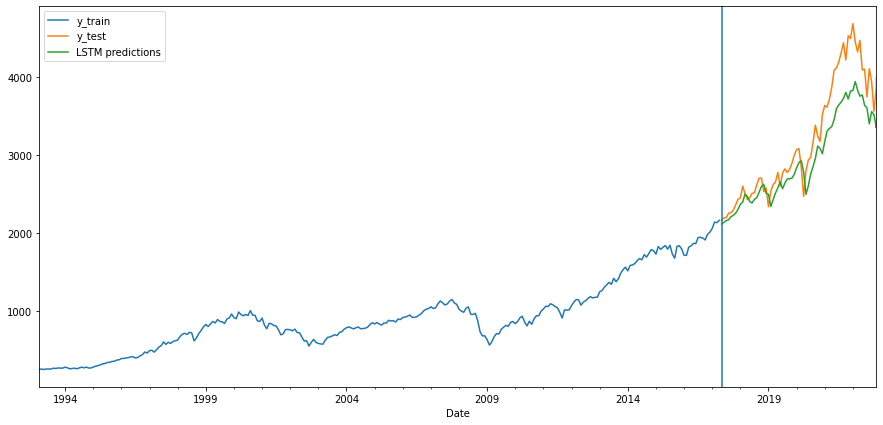

In [766]:
#@title ##**Predictions Plot** { display-mode: "form" }

y_train_0=pd.DataFrame(SP500_price_data["Adj Close"][:len(y_train)+2*time_steps+2], index = SP500_price_data["Adj Close"][:len(y_train)+2*time_steps+2].index) #convert train data into a dataframe and give it a Year-month-day index

y_test_0=pd.DataFrame(y_test, index = SP500_price_data["Adj Close"][len(y_train_0):].index)  #covert test data into a dataframe and give it a Year-month-day index

y_pred_0=pd.DataFrame(y_pred,index=SP500_price_data["Adj Close"][len(y_train_0):].index)  #covert predictions data into a dataframe and give it a Year-month-day index

ax = y_train_0.plot(legend=True, label='y_train', figsize=(15,7)) # plot training data configure plot size

y_test_0.plot(legend=True, label= 'y_test', ax=ax) #plot test data

y_pred_0.plot(legend=True, label='y_pred', ax=ax) #plot predictions

ax.legend(['y_train', 'y_test', 'LSTM predictions' ]) #add legend

plt.axvline(dt.datetime(int(SP500_price_data["Adj Close"][len(y_train_0):].index.year[0]),int(SP500_price_data["Adj Close"][len(y_train_0):].index.month[0]),int(SP500_price_data["Adj Close"][len(y_train_0):].index.day[0]))) #plot a vertical line on the date where predictions start

print("MAE: " + str(mean_absolute_error(y_test_0,y_pred_0))) #print MAE of the model

print("Comment:")
print("As we can see the MAE is very low but we can't compare with the previous model's MAE as it's not the same type of forecasting, because here we forcast one step at a time but in the previous one we forecasted many steps forward. ")
